## VAE

Import required packages

In [1]:
import torch
from torch import optim
from ResVAE import ResVariationalAutoEncoder  # Assuming you have a VAE model defined in 'model.py'
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from train import load_cw
import h5py

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAT_PATH = '../data/preprocessed.mat'

cw = load_cw(MAT_PATH)
cw_tensor = torch.tensor(cw).to(DEVICE)
train_data = TensorDataset(cw_tensor)

Training

In [7]:
# Configuration

INPUT_DIM = 100  # Adjusted input dimension to match your complex data
H_DIM = 50
Z_DIM = 25
H_LAYERS = [2,2,2,2,2,2,2]
LR_RATE = 1e-3
BATCH_SIZE = 1024

torch.manual_seed(717)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

## Init model
model = ResVariationalAutoEncoder(input_dim=INPUT_DIM, h_dim=H_DIM, h_layers=H_LAYERS, z_dim=Z_DIM).to(DEVICE)
model.initial()

## Load model
# model = torch.load('VAE_theta+bias1.pth')

optimizer = optim.Adam(model.parameters(), lr=LR_RATE, weight_decay=1e-5, betas=(0.5, 0.999))
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000,12000], gamma=0.5)

model.to(DEVICE)

loader_size = len(train_loader)
data_size = len(cw_tensor)
loss_list = np.zeros(loader_size)  # To store reconstruction diff losses
recon_loss_list = np.zeros(loader_size)  # To store reconstruction losses
kl_loss_list = np.zeros(loader_size)         # To store KL divergence losses


In [8]:
NUM_EPOCHS = 20000
KL_RATE = 0.01

model.train()
for epoch in range(NUM_EPOCHS):
    

    for i, [cw] in enumerate(train_loader):
        cw = cw.to(DEVICE, dtype=torch.float32).view(cw.shape[0], INPUT_DIM)
        x_reconstructed, mu, sigma = model(cw)

        # Compute loss
        loss, recon_loss, kl_loss = model.loss(x_reconstructed, cw, mu, sigma, KL_RATE)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Append losses to the lists
        loss_list[i] = loss.item()
        recon_loss_list[i] = recon_loss.item()
        kl_loss_list[i] = kl_loss.item()

    # Calculate and print average losses for this epoch
    # avg_loss = loss_list.sum() / data_size
    # avg_recon_loss = recon_loss_list.sum() / data_size
    # avg_kl_loss = kl_loss_list.sum() / data_size
    avg_loss = loss_list.mean()
    avg_recon_loss = recon_loss_list.mean()
    avg_kl_loss = kl_loss_list.mean()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{NUM_EPOCHS} | Loss: {avg_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}")
        
    if epoch % 100 == 0:
        torch.save(model, './VAE_theta+bias1.pth')


Epoch 0/20000 | Loss: 0.4130, Reconstruction: 0.4106, KL: 0.2420
Epoch 10/20000 | Loss: 0.3349, Reconstruction: 0.3343, KL: 0.0557
Epoch 20/20000 | Loss: 0.2876, Reconstruction: 0.2802, KL: 0.7393
Epoch 30/20000 | Loss: 0.2676, Reconstruction: 0.2579, KL: 0.9662
Epoch 40/20000 | Loss: 0.2679, Reconstruction: 0.2587, KL: 0.9188
Epoch 50/20000 | Loss: 0.2512, Reconstruction: 0.2415, KL: 0.9640
Epoch 60/20000 | Loss: 0.2514, Reconstruction: 0.2397, KL: 1.1647
Epoch 70/20000 | Loss: 0.2404, Reconstruction: 0.2287, KL: 1.1708
Epoch 80/20000 | Loss: 0.2358, Reconstruction: 0.2240, KL: 1.1781
Epoch 90/20000 | Loss: 0.2348, Reconstruction: 0.2236, KL: 1.1177
Epoch 100/20000 | Loss: 0.2586, Reconstruction: 0.2450, KL: 1.3567
Epoch 110/20000 | Loss: 0.2283, Reconstruction: 0.2143, KL: 1.4008
Epoch 120/20000 | Loss: 0.2272, Reconstruction: 0.2109, KL: 1.6262
Epoch 130/20000 | Loss: 0.2409, Reconstruction: 0.2273, KL: 1.3512
Epoch 140/20000 | Loss: 0.2196, Reconstruction: 0.2035, KL: 1.6081
Epoch 

Generate Data

In [9]:
def generate(num=1, mu_vals=None, sigma_vals=None, z_dim=Z_DIM):
    if mu_vals is None:
        mu = torch.zeros(1, z_dim).to(DEVICE, dtype=torch.float)
    else:
        mu = torch.tensor(mu_vals).to(DEVICE, dtype=torch.float).view(1, z_dim)

    if sigma_vals is None:
        sigma = torch.ones(1, z_dim).to(DEVICE, dtype=torch.float)
    else:
        sigma = torch.tensor(sigma_vals, dtype=torch.float).to(DEVICE).view(1, z_dim)

    generated_data = []
    
    model.eval()
    with torch.no_grad():
        for _ in range(num):
            out = model.generate(mu, sigma)
            generated_data.append(out)

    # Convert the generated data to a numpy array
    generated_data = torch.cat(generated_data, dim=0)

    return generated_data.cpu().detach().numpy()


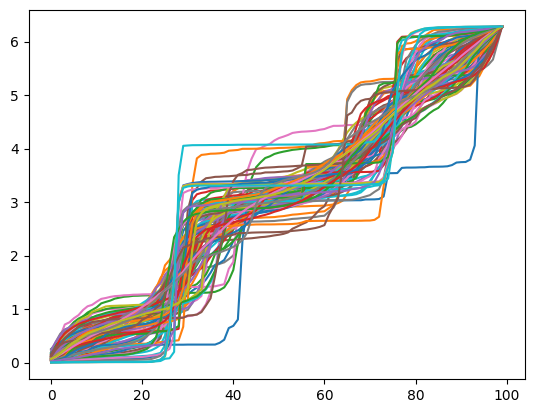

In [12]:
n = 100

generated_data = generate(num=n, sigma_vals=np.repeat(0.3, Z_DIM))
# groud_truth 
# generated_data = cw.cpu().numpy()[np.random.choice(range(cw.shape[0]),n)]

angle = np.cumsum(generated_data, axis=1)

for i in range(angle.shape[0]):
    plt.plot(angle[i])

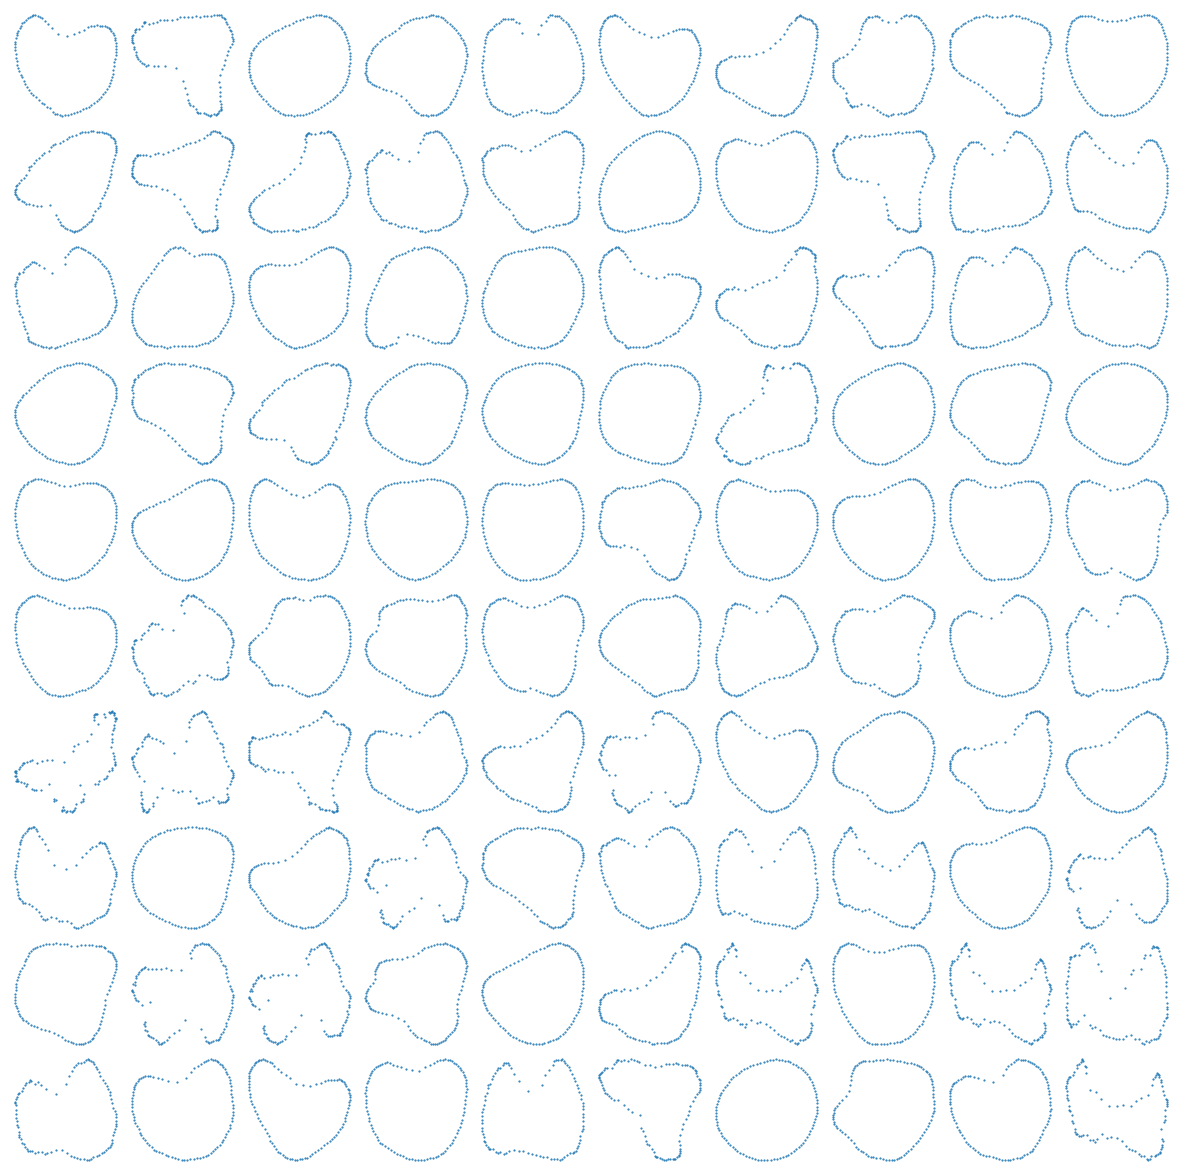

In [13]:
from geodesicwelding import geodesicwelding
from matplotlib import pyplot as plt

x = np.linspace(0, 2*np.pi, INPUT_DIM+1)[:INPUT_DIM]
xs = np.exp(1j * x)

x_num = 10
y_num = int(np.floor(n / x_num))
subfigure_size = 1.5

fig = plt.figure(figsize=(x_num*subfigure_size, y_num*subfigure_size))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(n):
    ys = np.exp(1j * angle[i])
    try:
        r, _ = geodesicwelding(ys, [], ys, xs)
    except:
        pass
    
    plt.subplot(x_num, y_num, i+1)
    plt.scatter(r.real, r.imag, s=0.3)
    plt.axis('off')